<a href="https://colab.research.google.com/github/he16946/Data_Labs/blob/master/Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spotify Data

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import (cross_validate, cross_val_score, KFold,
                                      train_test_split, StratifiedKFold)
from sklearn.tree import DecisionTreeClassifier,  DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

## Downloading data

In [2]:
os.environ['KAGGLE_USERNAME'] = "ce889group3" # username from the json file

os.environ['KAGGLE_KEY'] = "f0ec34f29bf37cceb765b25f5a1bce2c" # key from the json file

!kaggle datasets download -d geomack/spotifyclassification

  0% 0.00/98.4k [00:00<?, ?B/s]
100% 98.4k/98.4k [00:00<00:00, 37.2MB/s]


In [0]:
! unzip -q "spotifyclassification.zip"

In [0]:
df = pd.read_csv("data.csv")

In [5]:
df.columns

Index(['Unnamed: 0', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'target',
       'song_title', 'artist'],
      dtype='object')

In [6]:
print("Total count: ", df['target'].count())

Total count:  2017


In [7]:
print("Liked: ", df['target'].value_counts()[1])
print("Disliked: ", df['target'].value_counts()[0])

Liked:  1020
Disliked:  997


In [8]:
print('Like', round(df['target'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('Dislike', round(df['target'].value_counts()[0]/len(df) * 100,2), '% of the dataset')

Like 50.57 % of the dataset
Dislike 49.43 % of the dataset


## Creating the imbalance

To create the ratio 60 : 40 we reduce the number of disliked songs to 612. 

First the two categories are split:

In [0]:
like = df.loc[df['target'] == 1]
dislike = df.loc[df['target'] == 0]

612 random rows are obtained from the Dislikes

In [0]:
newdis = dislike.sample(n = 612, random_state = 1)

In [0]:
imb = [like, newdis]
imb = pd.concat(imb)

In [12]:
print('Like', round(imb['target'].value_counts()[1]/len(imb) * 100,2), '% of the dataset')
print('Dislike', round(imb['target'].value_counts()[0]/len(imb) * 100,2), '% of the dataset')

Like 62.5 % of the dataset
Dislike 37.5 % of the dataset


## Preprocessing

In [13]:
imb.head()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


Song title and Artist name columns are removed

In [0]:
imb = imb.drop(['song_title', 'artist'], axis = 1)

In [15]:
norm = ((imb - imb.min())/(imb.max()-imb.min()))
norm.columns

Index(['Unnamed: 0', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'target'],
      dtype='object')

## Cross-validation

In [16]:
features = list(norm.columns[1:14])
print(features)

['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']


In [0]:
x = norm[features]
y = norm['target']

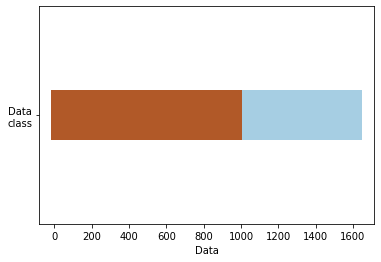

In [94]:
cmap_data = plt.cm.Paired
def visualize_classes(classes):
    fig, ax = plt.subplots()
    ax.scatter(range(len(classes)),  [3.5] * len(classes), c=classes, marker='_',
               lw=50, cmap=cmap_data)
    ax.set(yticks=[3.5],
           yticklabels=['Data\nclass'], xlabel="Data")


visualize_classes(y)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

**KFold Cross validation**

In [0]:
stnd = StandardScaler()
logit = LogisticRegression()
pipeline = make_pipeline(stnd, logit)
kf = KFold(n_splits = 10)

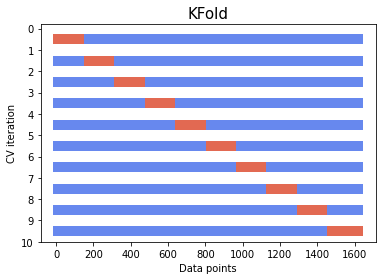

In [0]:
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    ax.set(yticks=np.arange(n_splits+2),
           xlabel='Data points', ylabel="CV iteration",
           ylim=[n_splits, -.2])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

fig, ax = plt.subplots()
plot_cv_indices(kf, x, y, ax, 10)

In [95]:
cv_results = cross_val_score(pipeline, x, y, cv=kf,scoring="accuracy", n_jobs=-1)
cv_results.mean()

0.6550276821786623

In [0]:
skf = StratifiedKFold(n_splits=10, shuffle = True)
skf.split(skf, x, y)

## Classifieres

**Dummy Classifier**

In [19]:
dummy = DummyClassifier(strategy='uniform', random_state=1)
dummy.fit(x_train, y_train)
print("Score: ", dummy.score(x_test, y_test))

Score:  0.4877450980392157


**Decision Tree**

In [42]:
dt = DecisionTreeClassifier(min_samples_split = 30, max_depth = 4, random_state = 32)
dt.fit(x_train, y_train)
print("Test score: ", dt.score(x_test, y_test))
print("CrossVal score: ", cross_validate(dt, x_test, y_test, cv = 10)['test_score'].mean())

Test score:  0.75
CrossVal score:  0.7232317073170732


Feature importances 

> Last 5 features have zero importance

Feature ranking:
1. instrumentalness (0.281054)
2. speechiness (0.219130)
3. energy (0.184061)
4. danceability (0.142444)
5. loudness (0.099700)
6. valence (0.048248)
7. tempo (0.025363)
8. time_signature (0.000000)
9. mode (0.000000)
10. liveness (0.000000)
11. key (0.000000)
12. duration_ms (0.000000)
13. acousticness (0.000000)


(0.0, 0.29510703155819556)

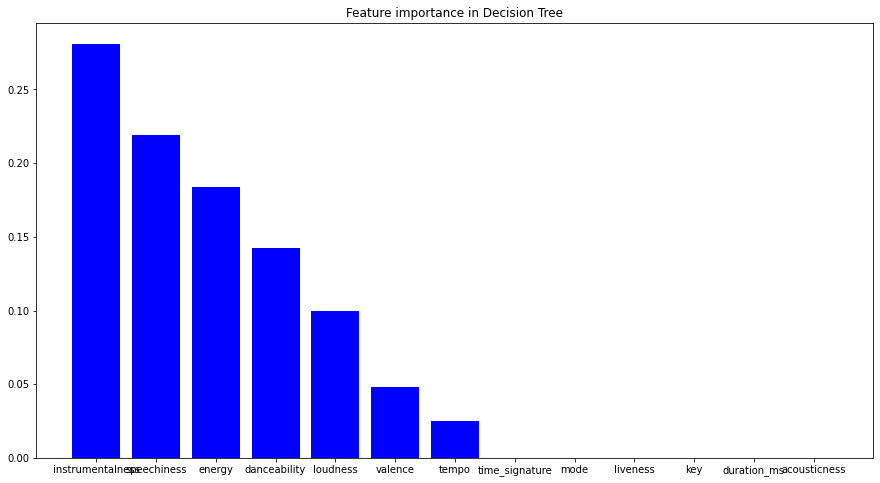

In [49]:
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(x.shape[1]):
  print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]])) 

fig = plt.figure()
plt.title("Feature importance in Decision Tree")
plt.bar(range(x.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(x.shape[1]), np.array(features)[indices])
plt.xlim([-1, x.shape[1]])
fig.set_size_inches(15, 8)
axes = plt.gca()
axes.set_ylim([0, None])

**Random Forest**

In [43]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 4, random_state = 32)
rf.fit(x_train, y_train)
print("Test score: ", rf.score(x_test, y_test))
print("CrossVal score: ", cross_validate(rf, x_test, y_test, cv = 10)['test_score'].mean())

Test score:  0.7524509803921569
CrossVal score:  0.7257317073170731


Feature importances

> All features have non-zero importance

Feature ranking:
1. instrumentalness (0.281054)
2. speechiness (0.219130)
3. energy (0.184061)
4. danceability (0.142444)
5. loudness (0.099700)
6. valence (0.048248)
7. tempo (0.025363)
8. time_signature (0.000000)
9. mode (0.000000)
10. liveness (0.000000)
11. key (0.000000)
12. duration_ms (0.000000)
13. acousticness (0.000000)


(0.0, 0.43422091538404245)

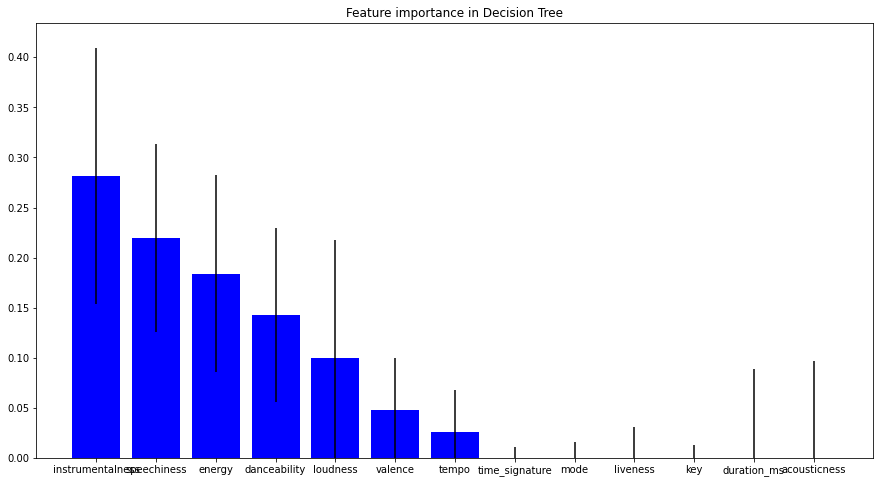

In [133]:
importances = dt.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(x.shape[1]):
  print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]])) 

fig = plt.figure()
plt.title("Feature importance in Decision Tree")
plt.bar(range(x.shape[1]), importances[indices], color="b", yerr=std[indices],align="center")
plt.xticks(range(x.shape[1]), np.array(features)[indices])
plt.xlim([-1, x.shape[1]])
fig.set_size_inches(15, 8)
axes = plt.gca()
axes.set_ylim([0, None])

**Decision Tree Regressor**

In [48]:
tr = DecisionTreeRegressor(random_state = 0, max_depth = 4, min_samples_split= 30)
tr.fit(x_train, y_train)
print("Test score: ", tr.score(x_test, y_test))
print("CrossVal score: ", cross_validate(tr, x_test, y_test, cv = 10)['test_score'].mean())

Test score:  0.2530577326537463
CrossVal score:  0.15319048583352074
